# TF-Agents-CartPole

> "Reinforcement Learning (RL) to control the balancing of a pole on a moving cart."
- toc: true
- branch: master
- badges: false
- comments: true
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2
- image: images/graphical_representation_of_rl.png
- categories: [Control,   RL,   TensorFlow,TF-Agents,Python]
- show_tags: true

In [2]:
#hide
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)
# root_dir = "/content/gdrive/My Drive/"
# base_dir = root_dir + 'RL/TF-Agents/blog_posts/TF-Agents-CartPole/'
# # base_dir = ""

Mounted at /content/gdrive


## 1. Introduction

The cart-pole problem can be considered as the "Hello World" problem of Reinforcement Learning (RL). It was described by [Barto (1983)](http://www.derongliu.org/adp/adp-cdrom/Barto1983.pdf). The physics of the system is as follows:

* All motion happens in a vertical plane
* A hinged pole is attached to a cart
* The cart slides horizontally on a track in an effort to balance the pole vertically
* The system has four state variables:

$x$: displacement of the cart

$\theta$: vertical angle on the pole

$\dot{x}$: velocity of the cart

$\dot{\theta}$: angular velocity of the pole


Here is a graphical representation of the system:

![Cartpole environment](https://raw.githubusercontent.com/tensorflow/agents/master/docs/tutorials/images/cartpole.png)

## 2. Purpose

The purpose of our activity in this blog post is to construct and train an entity, let's call it a *controller*, that can manage the horizontal motions of the cart so that the pole remains as close to vertical as possible. The controlled entity is, of course, the *cart and pole* system.

## 3. TF-Agents Setup

We will use the Tensorflow TF-Agents framework. In addition, this notebook will need to run in Google Colab.

In [3]:
!sudo apt-get install -y xvfb ffmpeg
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install tf-agents

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
xvfb is already the newest version (2:1.19.6-1ubuntu4.8).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [4]:
from __future__ import absolute_import, division, print_function
import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import tensorflow as tf
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

In [5]:
tf.version.VERSION

'2.4.0'

The following is needed for rendering a virtual display:

In [6]:
tf.compat.v1.enable_v2_behavior()
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [7]:
# ![Figure 1 Graphical Representation](../images/graphical_representation_of_rl.png)
# ![Figure 1 Graphical Representation](/content/gdrive/My Drive/RL/TF-Agents/blog_posts/TF-Agents-CartPole/graphical_representation_of_rl.png)


In [8]:
base_dir

'/content/gdrive/My Drive/RL/TF-Agents/blog_posts/TF-Agents-CartPole/'

## 4. Hyperparameters
Here we specify all the hyperparameters for the problem:

In [9]:
NUM_ITERATIONS = 20000

INITIAL_COLLECT_STEPS = 100
COLLECT_STEPS_PER_ITERATION = 1
REPLAY_BUFFER_MAX_LENGTH = 100000

BATCH_SIZE = 64
LEARNING_RATE = 1e-3
LOG_INTERVAL = 200

NUM_EVAL_EPISODES = 10
EVAL_INTERVAL = 1000

## 5. Graphical Representation of the Problem

We will work with a graphical representation of our cart-and-pole problem, rather than to just ramble on with words. This will enhance the description. The graphic will also include some TF-Agents specifics. Here is the representation:

![Figure 1 Graphical Representation](./graphical_representation_of_rl.png)

In [10]:
# import Image
im = PIL.Image.open(base_dir+'graphical_representation_of_rl.png')

## 6. Environment

Let's start with the controller. In Reinforcement Learning, the controlled entity is known as an **environment**. The TF-Agents framework contain some ready to use environments that can be created in TF-Agents using the `tf_agents.environments` suites. Fortunately, it makes access to the cart-and-pole environment (setup by OpenAI Gym) easy. Next, we load the cart-and-pole environment from the OpenAI Gym suite. 

In [11]:
env_name = 'CartPole-v0'
env = suite_gym.load(env_name)

You can render this environment to see how it looks. A free-swinging pole is attached to a cart.  The goal is to move the cart right or left in order to keep the pole pointing up. To verify, we can inspect our loaded environment with:

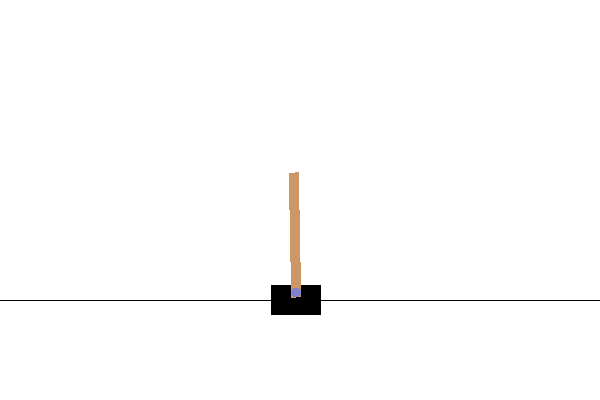

In [12]:
env.reset()
PIL.Image.fromarray(env.render())

### Input to Environment

The specification of inputs to the environment is provided by the `env.action_spec` method:

In [13]:
env.action_spec()

BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)

`shape` specifies the structure of the input which is a scalar in this case. `dtype` is the data type which is an `int64`. The `minimum` value of the action is `0` and the `maximum` is `1`. We will use the convention that the `action` on the cart is as follows:

* `0` means LEFT
* `1` means RIGHT

### Evolution of the Environment

The arrival of an `action` at the input of the environment leads to the update of its state. This is how the environment evolves. To advance the state of the environment, the `environment.step` method takes an input `action` and returns a `TimeStep` tuple containing the next observation of the environment and the reward for the action.



### Output from Environment

The specification of output from the environment is provided by the `env.time_step_spec` method:

In [14]:
env.time_step_spec()

TimeStep(step_type=ArraySpec(shape=(), dtype=dtype('int32'), name='step_type'), reward=ArraySpec(shape=(), dtype=dtype('float32'), name='reward'), discount=BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0), observation=BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]))

This specification has the following fields:

In [15]:
env.time_step_spec()._fields

('step_type', 'reward', 'discount', 'observation')

The `step_type` indicates whether a step is the first step, a middle step, or the last step in an episode:

In [16]:
env.time_step_spec().step_type

ArraySpec(shape=(), dtype=dtype('int32'), name='step_type')

The `reward` is a scalar which conveys the reward from the environment:

In [17]:
env.time_step_spec().reward

ArraySpec(shape=(), dtype=dtype('float32'), name='reward')

The `discount` is a factor that modifies the `reward`:

In [18]:
env.time_step_spec().discount

BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0)

The `observation` is the observable state of the environment:

In [19]:
env.time_step_spec().observation

BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])

In this case we have a vector with 4 elements - one each for the cart displacement, cart velocity, pole angle, and pole angular velocity. 

### Demonstrate the evolution of the environment

Let's submit 10 `RIGHT` actions to the environment, just for fun:


It is interesting to see an agent actually performing a task in an environment. 

First, create a function to embed videos in the notebook.

In [20]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

Now iterate through a few episodes of the Cartpole game with the agent. The underlying Python environment (the one "inside" the TensorFlow environment wrapper) provides a `render()` method, which outputs an image of the environment state. These can be collected into a video.

In [21]:
def create_video(filename, action, num_steps=10, fps=30):
  filename = filename + ".mp4"
  env.reset()
  with imageio.get_writer(filename, fps=fps) as video:
    video.append_data(env.render())
    for _ in range(num_steps):
      tstep = env.step(action); print(tstep)
      video.append_data(env.render())
  return embed_mp4(filename)

In [22]:
action = np.array(1, dtype=np.int32) #move RIGHT action

In [23]:
# create_video("untrained-agent", action, 50)

We will use two environments: one for training and one for evaluation. 

In [24]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

### Convert environments to TensorFlow

The Cartpole environment, like most environments, is written in pure Python. This is converted to TensorFlow using the `TFPyEnvironment` wrapper.

The original environment's API uses Numpy arrays. The `TFPyEnvironment` converts these to `Tensors` to make it compatible with Tensorflow agents and policies.


In [25]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

## 7. Agent

The controller in our problem is the algorithm used to solve the problem. In RL parlance the controller is known as an `Agent`. TF-Agents provides standard implementations of a variety of `Agents`, including:

-   [DQN](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf)
-   [REINFORCE](https://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf)
-   [DDPG](https://arxiv.org/pdf/1509.02971.pdf)
-   [TD3](https://arxiv.org/pdf/1802.09477.pdf)
-   [PPO](https://arxiv.org/abs/1707.06347)
-   [SAC](https://arxiv.org/abs/1801.01290).

For our problem we will use the DQN agent. The DQN agent can be used in any environment which has a discrete action space.

The fundamental problem for an Agent is how to find the next best action to submit to the environment. In the case of a DQN Agent the agent makes use of a `QNetwork`, which is a neural network model that can learn to predict `QValues` (expected returns) for all actions, given an observation from the environment. By inspecting the `QValues`, the agent can decide on the best next action.

### QNetwork

We use `tf_agents.networks.q_network` to create a `QNetwork`, passing in the `observation_spec`, `action_spec`, and a tuple `fc_layer_params` describing the number and size of the model's hidden layers. Each value in the tuple specifies the number of neurons for that hidden layer:


In [26]:
fc_layer_params = (100,)
q_net = q_network.QNetwork(
    input_tensor_spec= train_env.observation_spec(), 
    action_spec=       train_env.action_spec(), 
    fc_layer_params=   fc_layer_params)

### DqnAgent
We now use `tf_agents.agents.dqn.dqn_agent` to instantiate a `DqnAgent`. In addition to the `time_step_spec`, `action_spec` and the QNetwork, the agent constructor also requires an optimizer (in this case, `AdamOptimizer`), a loss function, and an integer step counter.

In [27]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=LEARNING_RATE)
train_step_counter = tf.Variable(0)
agent = dqn_agent.DqnAgent(
    time_step_spec=     train_env.time_step_spec(),
    action_spec=        train_env.action_spec(),
    q_network=          q_net,
    optimizer=          optimizer,
    td_errors_loss_fn=  common.element_wise_squared_loss,
    train_step_counter= train_step_counter)
agent.initialize()

### Policies

A policy defines the way an agent acts relative to the environment. The goal of reinforcement learning is to train the underlying model until the policy produces the desired outcome.

In this problem:

-   The desired outcome is keeping the pole balanced vertically over the cart
-   The policy returns an action (LEFT or RIGHT) for each `TimeStep`'s `observation`

Agents contain two policies: 

-   `agent.policy` — The main policy that is used for evaluation and deployment.
-   `agent.collect_policy` — A second policy that is used for data collection.


In [28]:
eval_policy = agent.policy
eval_policy

In [29]:
collect_policy = agent.collect_policy
collect_policy

Policies can be created independently of agents. For example, use `tf_agents.policies.random_tf_policy` to create a policy which will randomly select an action for each `time_step`.

In [30]:
random_policy = random_tf_policy.RandomTFPolicy(
    time_step_spec= train_env.time_step_spec(), 
    action_spec=    train_env.action_spec())

To get an action from a policy, call the `policy.action(tstep)` method. The `tstep` of type `TimeStep` contains the observation from the environment. This method returns a `PolicyStep`, which is a named tuple with three components:

-   `action` — the action to be taken (in this case, `0` or `1`)
-   `state` — used for stateful (that is, RNN-based) policies
-   `info` — auxiliary data, such as log probabilities of actions

Let's create an example environment and setup a random policy:

In [31]:
example_environment = tf_py_environment.TFPyEnvironment(
    suite_gym.load('CartPole-v0'))

We reset this environment:

In [32]:
tstep = example_environment.reset()
tstep

TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>, reward=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.04777068, -0.02450945, -0.03095539, -0.01279974]],
      dtype=float32)>)

In [33]:
tstep._fields

('step_type', 'reward', 'discount', 'observation')

In [34]:
print(tstep.step_type)
print(tstep.reward)
print(tstep.discount)
print(tstep.observation)

tf.Tensor([0], shape=(1,), dtype=int32)
tf.Tensor([0.], shape=(1,), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
tf.Tensor([[ 0.04777068 -0.02450945 -0.03095539 -0.01279974]], shape=(1, 4), dtype=float32)


Now we find the `PolicyStep` from which the next `action` can be found:

In [35]:
pstep = random_policy.action(tstep)
pstep

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>, state=(), info=())

In [36]:
pstep._fields

('action', 'state', 'info')

In [37]:
print(pstep.action)
print(pstep.state)
print(pstep.info)

tf.Tensor([0], shape=(1,), dtype=int64)
()
()


## 8. Metrics and Evaluation

The most common metric used to evaluate a policy is the **average return**. The return is the sum of rewards obtained while running a policy in an environment for an episode. Several episodes are run, creating an average return.

The following function computes the average return of a policy, given the policy, environment, and a number of episodes.


In [38]:
def compute_avg_return(env, pol, num_episodes=10):
  total_return = 0.0
  for _ in range(num_episodes):
    tstep = env.reset()
    episode_return = 0.0
    while not tstep.is_last():
      pstep = pol.action(tstep)
      tstep = env.step(pstep.action)
      episode_return += tstep.reward
    total_return += episode_return
  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]
# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

Running this computation on the `random_policy` shows a baseline performance in the environment.

In [39]:
NUM_EVAL_EPISODES

10

In [40]:
compute_avg_return(eval_env, random_policy, NUM_EVAL_EPISODES)

26.4

## 9. Replay Buffer

The replay buffer keeps track of data collected from the environment. We will use `tf_agents.replay_buffers.tf_uniform_replay_buffer.TFUniformReplayBuffer`, as it is the most common. 

The constructor requires the specs for the data it will be collecting. This is available from the agent using the `collect_data_spec` method. The batch size and maximum buffer length are also required.


In [41]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=  agent.collect_data_spec,
    batch_size= train_env.batch_size,
    max_length= REPLAY_BUFFER_MAX_LENGTH)

For most agents, `collect_data_spec` is a named tuple called `Trajectory`, containing the specs for observations, actions, rewards, and other items.

In [42]:
agent.collect_data_spec

Trajectory(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), observation=BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)), action=BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(1)), policy_info=(), next_step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)))

In [43]:
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

## 10. Data Collection

Now we execute the random policy in the environment for a few steps, recording the data in the replay buffer.

In [44]:
def collect_step(env, pol, buffer):
  tstep = env.current_time_step()
  pstep = pol.action(tstep)
  next_tstep = env.step(pstep.action)
  traj = trajectory.from_transition(tstep, pstep, next_tstep)
  buffer.add_batch(traj) # Add trajectory to the replay buffer

def collect_data(env, pol, buffer, steps):
  for _ in range(steps):
    collect_step(env, pol, buffer)

collect_data(train_env, random_policy, replay_buffer, INITIAL_COLLECT_STEPS)

# This loop is so common in RL, that we provide standard implementations. 
# For more details see the drivers module.
# https://www.tensorflow.org/agents/api_docs/python/tf_agents/drivers

The replay buffer is now a collection of Trajectories. Let's inspect one of the Trajectories:

In [82]:
traj = iter(replay_buffer.as_dataset()).next()
print(type(traj))
print(len(traj))
print(traj);

<class 'tuple'>
2
(Trajectory(step_type=<tf.Tensor: shape=(), dtype=int32, numpy=1>, observation=<tf.Tensor: shape=(4,), dtype=float32, numpy=array([-0.01126854, -0.16798736,  0.10049265,  0.40535218], dtype=float32)>, action=<tf.Tensor: shape=(), dtype=int64, numpy=0>, policy_info=(), next_step_type=<tf.Tensor: shape=(), dtype=int32, numpy=1>, reward=<tf.Tensor: shape=(), dtype=float32, numpy=1.0>, discount=<tf.Tensor: shape=(), dtype=float32, numpy=1.0>), BufferInfo(ids=<tf.Tensor: shape=(), dtype=int64, numpy=34>, probabilities=<tf.Tensor: shape=(), dtype=float32, numpy=0.01>))


In [83]:
traj[0]

Trajectory(step_type=<tf.Tensor: shape=(), dtype=int32, numpy=1>, observation=<tf.Tensor: shape=(4,), dtype=float32, numpy=array([-0.01126854, -0.16798736,  0.10049265,  0.40535218], dtype=float32)>, action=<tf.Tensor: shape=(), dtype=int64, numpy=0>, policy_info=(), next_step_type=<tf.Tensor: shape=(), dtype=int32, numpy=1>, reward=<tf.Tensor: shape=(), dtype=float32, numpy=1.0>, discount=<tf.Tensor: shape=(), dtype=float32, numpy=1.0>)

In [84]:
type(traj[0])

tf_agents.trajectories.trajectory.Trajectory

In [85]:
traj[0]._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [86]:
print('step_type:', traj[0].step_type)
print('observation:', traj[0].observation)
print('action:', traj[0].action)
print('policy_info:', traj[0].policy_info)
print('next_step_type:', traj[0].next_step_type)
print('reward:', traj[0].reward)
print('discount:', traj[0].discount)

step_type: tf.Tensor(1, shape=(), dtype=int32)
observation: tf.Tensor([-0.01126854 -0.16798736  0.10049265  0.40535218], shape=(4,), dtype=float32)
action: tf.Tensor(0, shape=(), dtype=int64)
policy_info: ()
next_step_type: tf.Tensor(1, shape=(), dtype=int32)
reward: tf.Tensor(1.0, shape=(), dtype=float32)
discount: tf.Tensor(1.0, shape=(), dtype=float32)


In [87]:
traj[1]

BufferInfo(ids=<tf.Tensor: shape=(), dtype=int64, numpy=34>, probabilities=<tf.Tensor: shape=(), dtype=float32, numpy=0.01>)

In [88]:
type(traj[1])

tf_agents.replay_buffers.tf_uniform_replay_buffer.BufferInfo

In [89]:
traj[1]._fields

('ids', 'probabilities')

In [90]:
print('ids:', traj[1].ids)
print('probabilities:', traj[1].probabilities)

ids: tf.Tensor(34, shape=(), dtype=int64)
probabilities: tf.Tensor(0.01, shape=(), dtype=float32)


The agent needs access to the replay buffer. TF-Agents provide this access by creating an iterable `tf.data.Dataset` pipeline which will feed data to the agent.

Each row of the replay buffer only stores a single observation step. But since the DQN Agent needs both the current and next observation to compute the loss, the dataset pipeline will sample two adjacent rows for each item in the batch (`num_steps=2`).

The code also optimize this dataset by running parallel calls and prefetching data.

In [93]:
print(BATCH_SIZE)

64


In [92]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=BATCH_SIZE, 
    num_steps=2).prefetch(3)
dataset

<PrefetchDataset shapes: (Trajectory(step_type=(64, 2), observation=(64, 2, 4), action=(64, 2), policy_info=(), next_step_type=(64, 2), reward=(64, 2), discount=(64, 2)), BufferInfo(ids=(64, 2), probabilities=(64,))), types: (Trajectory(step_type=tf.int32, observation=tf.float32, action=tf.int64, policy_info=(), next_step_type=tf.int32, reward=tf.float32, discount=tf.float32), BufferInfo(ids=tf.int64, probabilities=tf.float32))>

In [94]:
iterator = iter(dataset)
print(iterator)

In [95]:
# Compare this representation of replay data 
# to the collection of individual trajectories shown earlier:
# iterator.next()

## 11. Training the agent

Two things must happen during the training loop:

-   collect data from the environment
-   use that data to train the agent's neural network(s)

This example also periodicially evaluates the policy and prints the current score.

The following will take ~5 minutes to run.

In [ ]:
# num_iterations = 20000 # @param {type:"integer"} #.

# initial_collect_steps = 100  # @param {type:"integer"} 
# collect_steps_per_iteration = 1  # @param {type:"integer"}
# replay_buffer_max_length = 100000  # @param {type:"integer"}

# batch_size = 64  # @param {type:"integer"}
# learning_rate = 1e-3  # @param {type:"number"}
# log_interval = 200  # @param {type:"integer"}

# num_eval_episodes = 10  # @param {type:"integer"}
# eval_interval = 1000  # @param {type:"integer"}

In [105]:
# NUM_ITERATIONS
NUM_ITERATIONS = 20000

In [106]:
#@test {"skip": true}
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, NUM_EVAL_EPISODES)
returns = [avg_return]

for _ in range(NUM_ITERATIONS):
  # Collect a few steps using collect_policy and save to the replay buffer
  collect_data(train_env, agent.collect_policy, replay_buffer, COLLECT_STEPS_PER_ITERATION)

  # Sample a batch of data from the buffer and update the agent's network
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % LOG_INTERVAL == 0:
    print(f'step = {step}: loss = {train_loss}')

  if step % EVAL_INTERVAL == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, NUM_EVAL_EPISODES)
    print(f'step = {step}: Average Return = {avg_return}')
    returns.append(avg_return)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs
step = 200: loss = 195.16213989257812
step = 400: loss = 226.61244201660156
step = 600: loss = 274.764892578125
step = 800: loss = 42.2076416015625
step = 1000: loss = 6.291749954223633
step = 1000: Average Return = 33.79999923706055
step = 1200: loss = 50.53717803955078
step = 1400: loss = 36.393985748291016
step = 1600: loss = 172.8566436767578
step = 1800: loss = 11.371061325073242
step = 2000: loss = 18.2037353515625
step = 2000: Average Return = 72.80000305175781
step = 2200: loss = 54.74932861328125
step = 2400: loss = 16.711841583251953
step = 2600: loss = 3.500059127807617
step = 2800: loss = 7.880290985107422
step = 3000: loss = 8.416237831115723
step = 3000: Average Return = 95.5999984741211
step = 3200: loss = 607.7373657226562
step = 3400: loss = 5.996950149536133
step = 3600: loss = 54.01152801513672
step = 3800: loss = 238.8196258544922
step = 4000: loss = 21.115650177001953
step = 4000: Average Return = 71.8

## Visualization


### Plots

Use `matplotlib.pyplot` to chart how the policy improved during training.

One iteration of `Cartpole-v0` consists of 200 time steps. The environment gives a reward of `+1` for each step the pole stays up, so the maximum return for one episode is 200. The charts shows the return increasing towards that maximum each time it is evaluated during training. (It may be a little unstable and not increase monotonically each time.)

(15.725, 250.0)

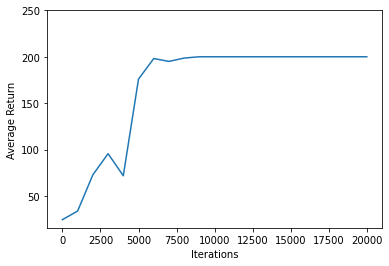

In [109]:
#@test {"skip": true}
iterations = range(0, NUM_ITERATIONS + 1, EVAL_INTERVAL)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)

### Videos

Charts are nice. But more exciting is seeing an agent actually performing a task in an environment. 

First, create a function to embed videos in the notebook.

In [110]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

Now iterate through a few episodes of the Cartpole game with the agent. The underlying Python environment (the one "inside" the TensorFlow environment wrapper) provides a `render()` method, which outputs an image of the environment state. These can be collected into a video.

In [111]:
# def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
def create_policy_eval_video(policy, filename, num_episodes=3, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)

In [112]:
create_policy_eval_video(agent.policy, "trained-agent")

For fun, compare the trained agent (above) to an agent moving randomly. (It does not do as well.)

In [113]:
create_policy_eval_video(random_policy, "random-agent")